## Step 3: Multi-level Multipole Expansion

Recall in the previous notebook, we grouped all the sources in the same cell. However, when the number of particles becomes very large, instead of grouping all the sources in a single cell, we need to build a hierachical structure to group the particles. The picture below shows a quadtree structure for a 2D particle distribution, where each parent cell (grey) can be split into 4 child cells (orange). From the previous lesson we know that the multipole of a cell only depends on the sources in that cell and the center of the cell, namely, the multipole is a "property" of a cell. 

<img src="image/m2m.png">

Now that multipole is a property of a cell, we should be able to evaluate the multipole of a parent cell given the multipole values of its child cells. That is our goal for this notebook! Here we use an octree to subdivide a parent cell into 8 child cells in 3D.

First, let's review the terms in the multipole of a child cell $c$. Notice we are only showing some terms, the remaining ones can be deducted by similarity:

$$\begin{equation}\begin{split}
M_c &= \sum_{j=0}^{N_c} m_j\\
D_{c_x} &= \sum_{j=0}^{N_c} m_j\,( x_c - x_j)\\
Q_{c_{xx}} &= \sum_{j=0}^{N_c} \frac{1}{2}m_j\, ( x_c - x_j)^2 \\
Q_{c_{xy}} &= \sum_{j=0}^{N_c} \frac{1}{2}m_j\, (x_c-x_j)(y_c-y_j) \\
\end{split}\end{equation}$$

where $N_c$ is the number of sources in the child cell, $x_c$ is the cell's center, $M$, $D$, $Q$ are respectively monopole, dipole and quadrupole. When we expand the particles from a smaller group (*child*) to a larger group (*parent*), we also need to shift the center of expansion from ($x_c$, $y_c$, $z_c$) to ($x_p$, $y_p$, $z_p$). Now we expand them in a parent cell $p$ with 8 child cells:

$$\begin{equation}\begin{split}
M_p &= \sum_{j=0}^N m_j = \sum_{c=0}^7 M_c\\
D_{p_x} &= \sum_{j=0}^N m_j\,( x_p - x_j) = \sum_{c=0}^7 \left[\sum_{j=0}^{N_c} m_j\,(x_c-x_j) + ( x_p-x_c)\sum_{j=0}^{N_c} m_j\right]\\
&= \sum_{c=0}^{7} \left[D_{c_x} + (x_p-x_c)\,M_c\right] \\
Q_{p_{xx}} &= \sum_{j=0}^N \frac{1}{2}m_j \,(x_p - x_j)^2 = \sum_{c=0}^7 \left[\sum_{j=0}^N \frac{1}{2}m_j\left[(x_c-x_j)+(x_p-x_c)\right]^2 \right]\\
&= \sum_{c=0}^7 \left[\sum_{j=0}^N \frac{1}{2}m_j (x_c - x_j)^2 + (x_p-x_c) \sum_{j=0}^N m_j(x_c-x_j) + \frac{(x_p-x_c)^2}{2} \sum_{j=0}^N m_j \right]\\
&= \sum_{c=0}^7 \left[Q_{c_{xx}} + (x_p-x_c)D_{c_{x}} + \frac{(x_p-x_c)^2}{2}M_c \right]\\
Q_{p_{xy}} &= \sum_{j=0}^{N} \frac{1}{2}m_j\, (x_p-x_j)(y_p-y_j) \\
&= \sum_{c=0}^7 \left[\sum_{j=0}^{N} \frac{1}{2}m_j(x_c-x_j)(y_c-y_j) + \frac{(x_p-x_c)}{2}\sum_{j=0}^{N}m_j(y_c-y_j) \right.\\
&+\left. \frac{(y_p-y_c)}{2}\sum_{j=0}^{N}m_j(x_c-x_j) + \frac{(x_p-x_c)(y_p-y_c)}{2}\sum_{j=0}^{N}m_j\right]\\
&= \sum_{c=0}^7 \left[ Q_{c_{xy}} +\frac{(x_p-x_c)}{2}D_{c_y} +\frac{(y_p-y_c)}{2}D_{c_x} + \frac{(x_p-x_c)(y_p-y_c)}{2}M_c \right]
\end{split}\end{equation}$$

Each multipole term $M_p$, $D_p$, $Q_p$ in parent cell can be expressed by a summation of its child's multipole terms $M_c$, $D_c$, $Q_c$. Therefore, we refer this expansion shifting process as **Multipole-to-Multipole** or **M2M**.

We use the same spatial distribution of sources and targets as the previous lesson, and they are well separated. We assume there are $n$ sources located in the domain: $x_j$, $y_j$, $z_j$ $\in$ $\left[ 0, 1 \right]$, while $n$ targets in the domain: $x_i$, $y_i$, $z_i$ $\in$ $\left[ -1, 0 \right]$.

This time we assign all the sources in the **parent** cell centered at $(0.5, 0.5, 0.5)$ with a side length of $1$. Then we subdivide the unit cube into 8 **child** cells to form an octree. The child's side length should be $0.5$. We index the $8$ child cells from $0$ to $7$, and calculate the coordinates of child's center based on the index (octant).

In [1]:
# importing libraries
import numpy
from treecode_helper import Particle, distance, l2_err, plot_err
from matplotlib import pyplot, rcParams
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

# customizing plot parameters
rcParams['figure.dpi'] = 100
rcParams['font.size'] = 16
rcParams['font.family'] = 'StixGeneral'

In [2]:
n = 50     # number of particles
m = 1/n    # mass

# initialize sources and targets
source_coords = numpy.random.random((n, 3)).tolist()
target_coords = (-numpy.random.random((n, 3))).tolist()
sources = [ Particle(coord, m=m) for coord in source_coords ]
targets = [ Particle(coord, m=m) for coord in target_coords ]

In [3]:
class Cell():
    """The class for a cell.
    
    Attributes:
        x, y, z: xyz coordinates of the cell's center
        multipole: the array of the cell's multipoles
    
    """
    def __init__(self, x=None, y=None, z=None):
        self.x = x
        self.y = y
        self.z = z
        self.multipole = numpy.zeros(10)

In [4]:
# create parent cell
parent = Cell(0.5, 0.5, 0.5)
# create an array of 8 child cells
octant = numpy.arange(8)
# use "//" as integer division and "/" as floating-point division
x = (octant % 2) * parent.x + parent.x/2
y = ((octant//2) % 2) * parent.y + parent.y/2
z = ((octant//4) % 2) * parent.z + parent.z/2
children = [Cell(x[i], y[i], z[i]) for i in range(8)]

After we create the octree, we need to loop over sources to distribute them into child cells. Then perform a P2M to calculate the multipoles for each child. The two steps both require loop in source $j$, therefore, we can merge them into one function.

In [5]:
def P2M(sources, parent, children):
    """Calculate the multipoles for child cells.
    
    Arguments:
        sources: the list of source objects in 'Particle' class
        parent: parent cell object
        children: the list of child cell objects
        
    """
    for source in sources:
        octant = (source.x > parent.x) + ((source.y > parent.y) << 1) \
                                       + ((source.z > parent.z) << 2)
        dx, dy, dz = children[octant].x-source.x,\
                     children[octant].y-source.y,\
                     children[octant].z-source.z
        
        children[octant].multipole += source.m*numpy.array((1, dx, dy, dz,\
                                                dx**2/2, dy**2/2, dz**2/2,\
                                                dx*dy/2, dy*dz/2, dz*dx/2))

The "two less than" sign $<<$ is a bit shift operator, if you are not familiarized with this you can find go to the [Bitwise Operators](https://wiki.python.org/moin/BitwiseOperators) wiki from python. The first line inside the loop is how we find the octant of a source particle. The RHS of the expression returns a integer from $0$ to $7$, representing one of the eight octants. Think about how this line of code works like a charm. It is in accordance with the way we generate the coordinates of the child cell's centers. In addition, since we have $8$ cells, the multipole array becomes a 2d array, the first argument refers to one of the eight octants, and the second is one of the ten multipole terms.

In [6]:
P2M(sources, parent, children)

Given the multipoles of the child cells, we can write the M2M kernel following the equations we just derived above. We also call this part "upward translation" since we shift the expansion center from child cell to parent cell.

The M2M kernel do not explicitly include the information of the sources as an input, instead it loops over each child cell and multipoles of child cells contain the information of sources $x_j$, $y_j$, $z_j$, $m_j$ in each octant. M2M returns the 10 multipole terms of the parent cell, which contains the information of all the sources in the domain.

In [7]:
def M2M(parent, children):
    """Given the child cells' multipoles, calculate the parent's multipoles.
    
    Arguments:
        parent: parent cell object
        children: the list of child cell objects
        
    """
    for child in children:
        dx, dy, dz = parent.x-child.x, parent.y-child.y, parent.z-child.z
        parent.multipole += child.multipole
        parent.multipole[1:4] += child.multipole[0] * numpy.array((dx, dy, dz))
        parent.multipole[4:7] += child.multipole[1:4] * numpy.array((dx, dy, dz))\
                                + 0.5*child.multipole[0] * numpy.array((dx**2, dy**2, dz**2))
        parent.multipole[7:] += 0.5*numpy.array((child.multipole[2], child.multipole[3], child.multipole[1])) * numpy.array((dx, dy, dz))\
                                + 0.5*child.multipole[1:4] * numpy.array((dy, dz, dx))\
                                + 0.5*child.multipole[0] * numpy.array((dx*dy, dy*dz, dz*dx)) 

In [8]:
M2M(parent, children)

Now we have the multipole array of the parent cell, so we can loop in targets in order to evaluate the potential at each target by an multipole expansion. (Recall multipole expansion in the previous notebook)

In [9]:
def eval_potential(targets, multipole, center):
    """Given targets list, multipole and expansion center, return
    the array of target's potentials.
    
    Arguments:
        targets: the list of target objects in 'Particle' class
        multipole: the multipole array of the cell
        center: the point object of expansion center
    
    Returns:
        phi: the potential array of targets
        
    """
    # prepare for array operation
    target_x = numpy.array([target.x for target in targets])
    target_y = numpy.array([target.y for target in targets])
    target_z = numpy.array([target.z for target in targets])
    target_array = [target_x, target_y, target_z]
    
    # calculate the distance between each target and center
    r = distance(target_array, center)
    
    # prearrange some constants for weight
    dx, dy, dz = target_x-center.x, target_y-center.y, target_z-center.z
    r3 = r**3
    r5 = r3*r**2
    
    # calculate the weight for each multipole
    weight = [1/r, -dx/r3, -dy/r3, -dz/r3, 3*dx**2/r5 - 1/r3, \
              3*dy**2/r5 - 1/r3, 3*dz**2/r5 - 1/r3, 3*dx*dy/r5, \
              3*dy*dz/r5, 3*dz*dx/r5]
    
    # evaluate potential
    phi = numpy.dot(multipole, weight)
    return phi

In [10]:
phi_multi = eval_potential(targets, parent.multipole, parent)

How should the domain looks like?

The black dot shows the parent's center, while the greens are the centers of child cells.


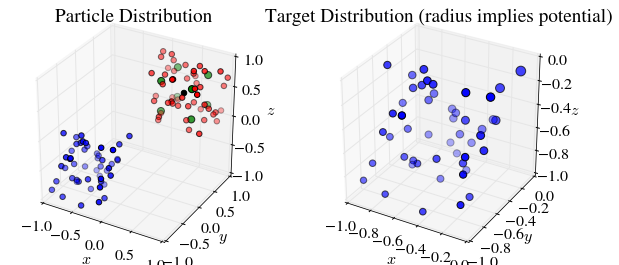

In [11]:
# plot spatial particle distribution
fig = pyplot.figure(figsize=(10,4.5))
# left plot
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter([target.x for target in targets], 
           [target.y for target in targets], 
           [target.z for target in targets], s=30, c='b')
ax.scatter([source.x for source in sources], 
           [source.y for source in sources], 
           [source.z for source in sources], s=30, c='r')

ax.scatter(x, y, z, s=50, c='g') #center of child cells

ax.scatter(parent.x, parent.y, parent.z, s=30, c='k') #center of parent cell

ax.set_xlim3d(-1,1)
ax.set_ylim3d(-1,1)
ax.set_zlim3d(-1,1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title('Particle Distribution')
# right plot
ax = fig.add_subplot(1,2,2, projection='3d')
scale = 100   # scale for dot size in scatter plot
ax.scatter([target.x for target in targets], 
           [target.y for target in targets], 
           [target.z for target in targets],
           s=phi_multi*scale, c='b')
ax.set_xlim3d(-1,0)
ax.set_ylim3d(-1,0)
ax.set_zlim3d(-1,0)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.set_title('Target Distribution (radius implies potential)');

In [12]:
def direct_sum(sources, targets):
    """Calculate the gravitational potential (target.phi) at each target 
    particle using direct summation method.

    Arguments:
        sources: the list of source objects in 'Particle' class
        targets: the list of target objects in 'Particle' class

    """
    for target in targets:
        for source in sources:
            r = target.distance(source)
            target.phi += source.m/r

In [13]:
direct_sum(sources, targets)
phi_direct = numpy.array([target.phi for target in targets])

Then we use direct summation method to calculate the potentials.

Compare the two results and calculate $L^2$ relative error norm.

In [14]:
l2_err(phi_direct, phi_multi)

L2 Norm error: 0.0017548017922207433


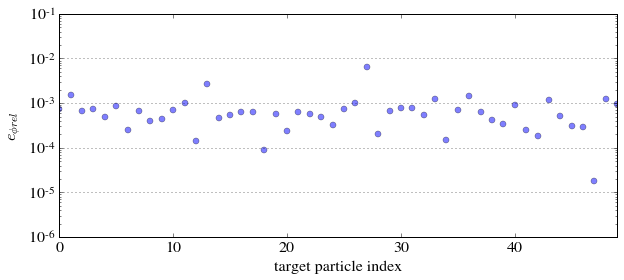

In [15]:
plot_err(phi_direct, phi_multi)

In [16]:
%timeit direct_sum(sources, targets)

100 loops, best of 3: 11.3 ms per loop


In [17]:
%%timeit
P2M(sources, parent, children)
M2M(parent, children)
eval_potential(targets, parent.multipole, parent)

1000 loops, best of 3: 1.48 ms per loop


The results show a good match between multi-level multipole expansion and direct summation. We first perform a P2M for each child cell to calculate the multipoles of child cell (expansion at the child's cell center). Then we use M2M kernel to calculate the multipole of parent cell (shift the expansion to the parent's cell center). Finally, we evaluate the potential by multipole expansion. Here we only have one parent cell and its eight child cells, however, when there are millions of particles, we need to build a more complex hierarchical tree to store the particles. Child cells may still have their child cells, and evaluation of the potentials may require a traverse of the tree. So in the next notebook, we will discuss how to 'construct' this tree of cells.

##### Reference

1. R. Yokota, 12 Steps to a Fast Multipole Method on GPUs, Pan-American Advanced Studies Institute, Valparaiso, Chile, 3-14 January, 2011.
2. Raykar, V. C., "[A short primer on the fast multipole method: FMM tutorial](http://www.umiacs.umd.edu/labs/cvl/pirl/vikas/publications/FMM_tutorial.pdf),", University of Maryland, College Park, Apr. 8, 2006.

In [18]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./style/fmmstyle.css', 'r').read()
    return HTML(styles)
css_styling()